In [81]:
from scipy.io import wavfile

sample_rate, signal = wavfile.read('Healthy.wav')

print(f"Sample Rate: {sample_rate} Hz")
print(f"Signal shape: {signal.shape}")

Sample Rate: 16000 Hz
Signal shape: (185753,)


In [82]:
from scipy.io import wavfile
import numpy as np
import scipy.signal as signal
from scipy.fftpack import dct
from scipy.signal import lfilter

rate_healthy, data_healthy = wavfile.read('Healthy.wav')
rate_parkinson, data_parkinson = wavfile.read('Parkinson\'s.wav')

print(f"Healthy - Rate: {rate_healthy}, Shape: {data_healthy.shape}")
print(f"Parkinson's - Rate: {rate_parkinson}, Shape: {data_parkinson.shape}")


Healthy - Rate: 16000, Shape: (185753,)
Parkinson's - Rate: 16000, Shape: (192500,)


In [83]:
import numpy as np
import scipy.signal as signal

def compute_jitter(signal_data, fs):

    crossings = np.where(np.diff(np.signbit(signal_data)))[0]
    periods = np.diff(crossings) / fs
    mean_period = np.mean(periods)
    jitter = np.sum(np.abs(np.diff(periods))) / ((len(periods) - 1) * mean_period)
    return jitter

jitter_healthy = compute_jitter(data_healthy, rate_healthy)
jitter_parkinson = compute_jitter(data_parkinson, rate_parkinson)

print("Jitter Healthy:", jitter_healthy)
print("Jitter Parkinson:", jitter_parkinson)


Jitter Healthy: 0.7167734626899749
Jitter Parkinson: 0.9223181595640366


In [84]:
def compute_shimmer_cycle_based(signal_data, fs):
    crossings = np.where(np.diff(np.signbit(signal_data)))[0]

    amplitudes = []
    for i in range(len(crossings) - 1):
        start = crossings[i]
        end = crossings[i + 1]
        if end > start:
            peak_to_peak = np.max(signal_data[start:end]) - np.min(signal_data[start:end])
            amplitudes.append(peak_to_peak)

    amplitudes = np.array(amplitudes)

    shimmer = np.mean(np.abs(np.diff(amplitudes))) / np.mean(amplitudes)
    return shimmer

shimmer_healthy = compute_shimmer_cycle_based(data_healthy, rate_healthy)
shimmer_parkinson = compute_shimmer_cycle_based(data_parkinson, rate_parkinson)
print("shimmer Healthy:", shimmer_healthy)
print("shimmer Parkinson:", shimmer_parkinson)

shimmer Healthy: 0.5943328296562043
shimmer Parkinson: 0.5512044061394127


In [85]:
from scipy.fftpack import dct

def mfcc_manual(signal_data, sample_rate, num_ceps=13):
    # Pre-emphasis
    emphasized = np.append(signal_data[0], signal_data[1:] - 0.97 * signal_data[:-1])

    # Framing
    frame_size = 0.025
    frame_stride = 0.01
    frame_length = int(round(frame_size * sample_rate))
    frame_step = int(round(frame_stride * sample_rate))
    signal_length = len(emphasized)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Hamming window
    frames *= np.hamming(frame_length)

    # FFT
    NFFT = 1
    while NFFT < frame_length:
       NFFT *= 2
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))
    print(f"NFFT: {NFFT}")

    # MFB
    nfilt = 26
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
    hz_points = (700 * (10 ** (mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    log_fbank = np.log(filter_banks)

    # DCT
    mfcc = dct(log_fbank, type=2, axis=1, norm='ortho')[:, :num_ceps]
    return mfcc

mfcc_healthy = mfcc_manual(data_healthy, rate_healthy)
mfcc_parkinson = mfcc_manual(data_parkinson, rate_parkinson)


NFFT: 512
NFFT: 512


In [86]:
def compute_lpc(signal_data, order=12):

    signal_data = signal_data.astype(float)

    padded_signal = np.pad(signal_data, (0, order), mode='constant')

    A = np.zeros((len(signal_data), order))
    for i in range(order):
        A[:, i] = padded_signal[i:i + len(signal_data)]

    b = padded_signal[order:order + len(signal_data)]

    lpc_coeffs, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    return np.concatenate(([1], -lpc_coeffs))

lpc_healthy = compute_lpc(data_healthy)
lpc_parkinson = compute_lpc(data_parkinson)

print("LPC Healthy:", lpc_healthy)
print("LPC Parkinson:", lpc_parkinson)

LPC Healthy: [ 1.         -0.07177254  0.27445764 -0.25932148 -0.23180572  0.37093797
  0.92299891 -3.04933413  3.39840899 -0.57348882 -3.18617951  4.73040582
 -3.30321483]
LPC Parkinson: [ 1.          0.12210448 -0.44160131  0.86496661 -1.00532794  1.01736533
 -1.29307375  1.13797305 -0.69703707  0.84030579 -1.38559258  2.20664965
 -2.3410693 ]


In [87]:
import numpy as np
from scipy.signal import find_peaks, lfilter
from scipy.signal.windows import hamming
from scipy.linalg import solve_toeplitz

def formant_freqs(signal, fs, order=12):
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    frame = emphasized_signal * hamming(len(emphasized_signal))

    autocorr = np.correlate(frame, frame, mode='full')
    autocorr = autocorr[len(autocorr)//2:]

    R = autocorr[:order+1]
    r = R[1:]
    lpc_coeffs = solve_toeplitz((R[:-1], R[:-1]), r)
    lpc_coeffs = np.insert(-lpc_coeffs, 0, 1)


    roots = np.roots(lpc_coeffs)
    roots = [r for r in roots if np.imag(r) >= 0]

    angles = np.angle(roots)

    freqs = angles * (fs / (2 * np.pi))

    formants = sorted(freqs)
    return formants[:4]

In [88]:
import matplotlib.pyplot as plt
import numpy as np

In [89]:
def plot_mfcc(mfccs, title="MFCC"):
    plt.figure(figsize=(10, 4))
    plt.imshow(mfccs.T, aspect='auto', origin='lower', cmap='viridis')
    plt.title(title)
    plt.xlabel("Frames")
    plt.ylabel("MFCC Coefficients")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


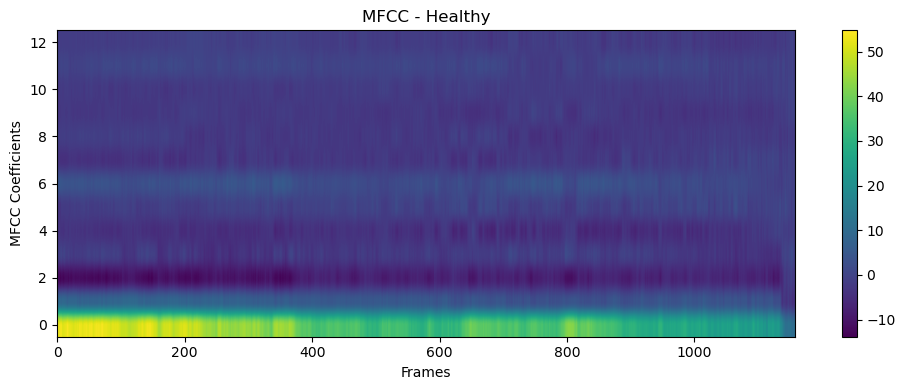

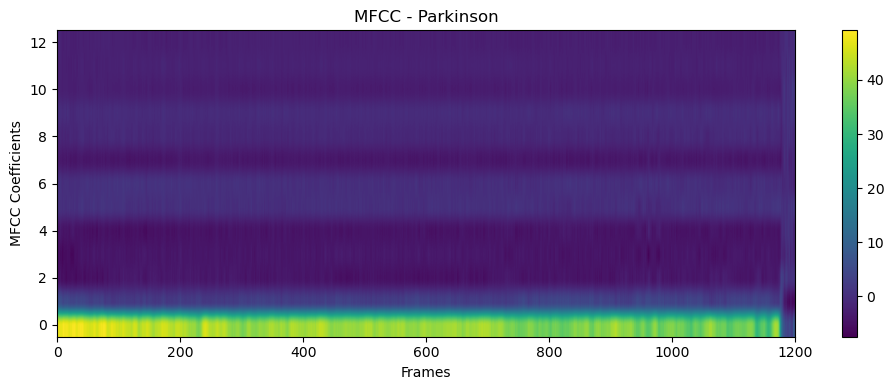

In [90]:
plot_mfcc(mfcc_healthy, "MFCC - Healthy")
plot_mfcc(mfcc_parkinson, "MFCC - Parkinson")

In [91]:
def plot_lpc(lpc_coeffs, title="LPC Coefficients"):
    plt.figure(figsize=(8, 4))
    plt.stem(range(len(lpc_coeffs)), lpc_coeffs)
    plt.title(title)
    plt.xlabel("Coefficient Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

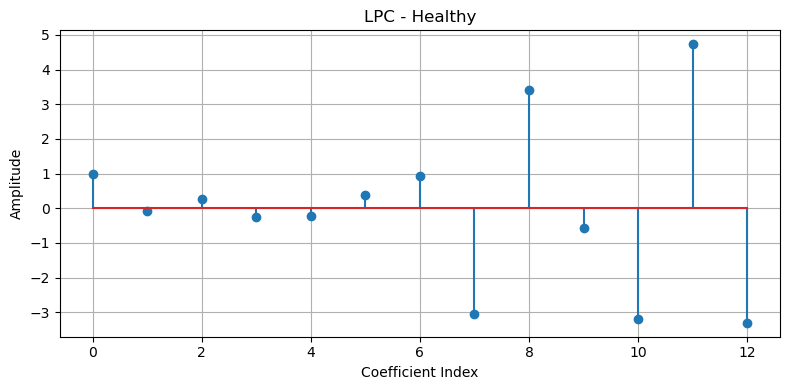

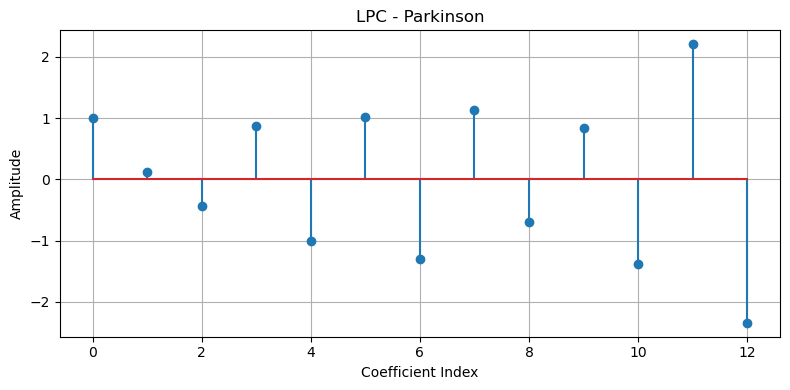

In [92]:
plot_lpc(lpc_healthy, "LPC - Healthy")
plot_lpc(lpc_parkinson, "LPC - Parkinson")

In [93]:
def plot_feature_comparison(healthy_val, parkinson_val, feature_name):
    plt.figure(figsize=(5, 3))
    plt.bar(["Healthy", "Parkinson"], [healthy_val, parkinson_val], color=["green", "red"])
    plt.title(f"{feature_name} Comparison")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()


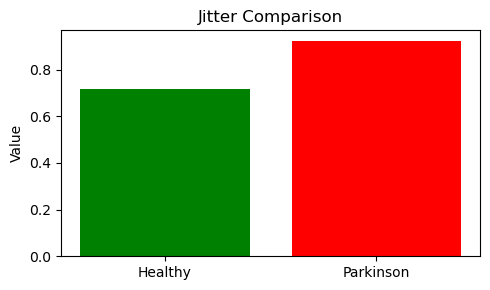

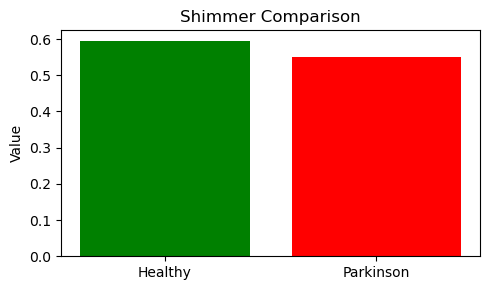

In [94]:
plot_feature_comparison(jitter_healthy, jitter_parkinson, "Jitter")
plot_feature_comparison(shimmer_healthy, shimmer_parkinson, "Shimmer")

In [95]:
def plot_signal_feature_over_time(signal, feature, title="Feature Over Time", sample_rate=16000):
    times = np.linspace(0, len(signal) / sample_rate, len(feature))
    plt.figure(figsize=(10, 4))
    plt.plot(times, feature)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

In [96]:
import matplotlib.pyplot as plt
import numpy as np

def plot_waveform(signal_data, sample_rate, title="Voice Waveform"):

    time_axis = np.linspace(0, len(signal_data) / sample_rate, num=len(signal_data))
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, signal_data, color='blue')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


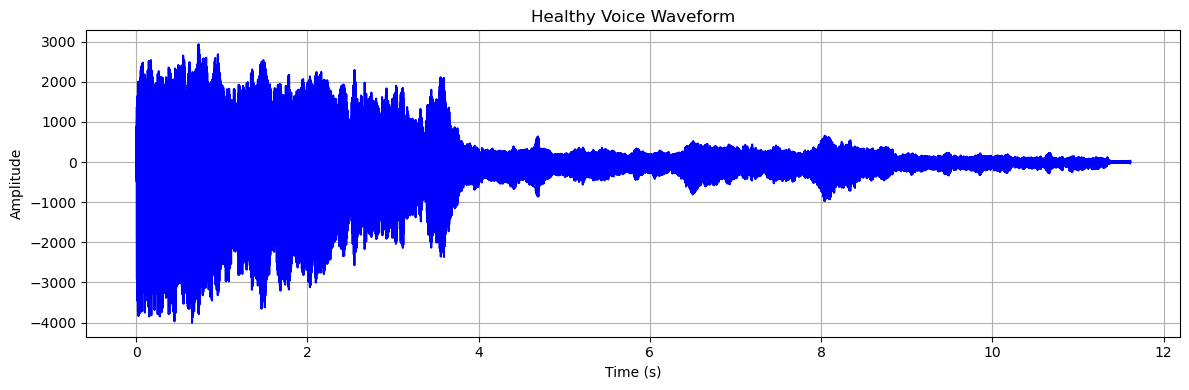

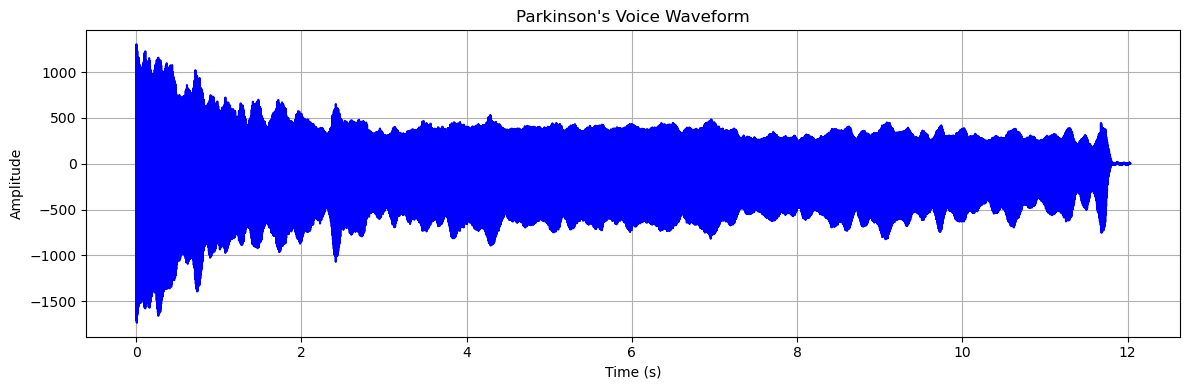

In [97]:
plot_waveform(data_healthy, rate_healthy, "Healthy Voice Waveform")
plot_waveform(data_parkinson, rate_parkinson, "Parkinson's Voice Waveform")

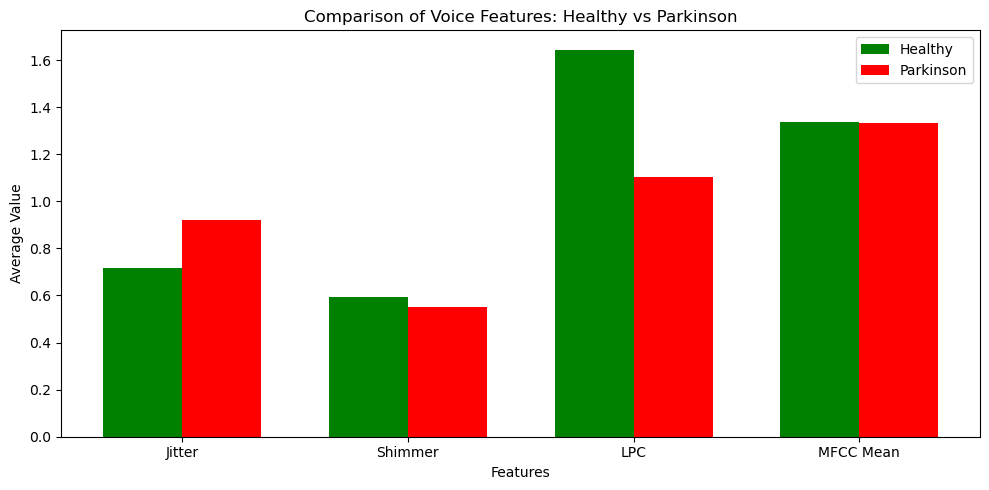

In [98]:
import matplotlib.pyplot as plt
import numpy as np

features = ['Jitter', 'Shimmer', 'LPC', 'MFCC Mean']
healthy_values = [jitter_healthy, shimmer_healthy, np.mean(np.abs(lpc_healthy)), np.mean(mfcc_healthy)]
parkinson_values = [jitter_parkinson, shimmer_parkinson, np.mean(np.abs(lpc_parkinson)), np.mean(mfcc_parkinson)]

x = np.arange(len(features))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, healthy_values, width, label='Healthy', color='green')
plt.bar(x + width/2, parkinson_values, width, label='Parkinson', color='red')

plt.xlabel('Features')
plt.ylabel('Average Value')
plt.title('Comparison of Voice Features: Healthy vs Parkinson')
plt.xticks(x, features)
plt.legend()
plt.tight_layout()
plt.show()


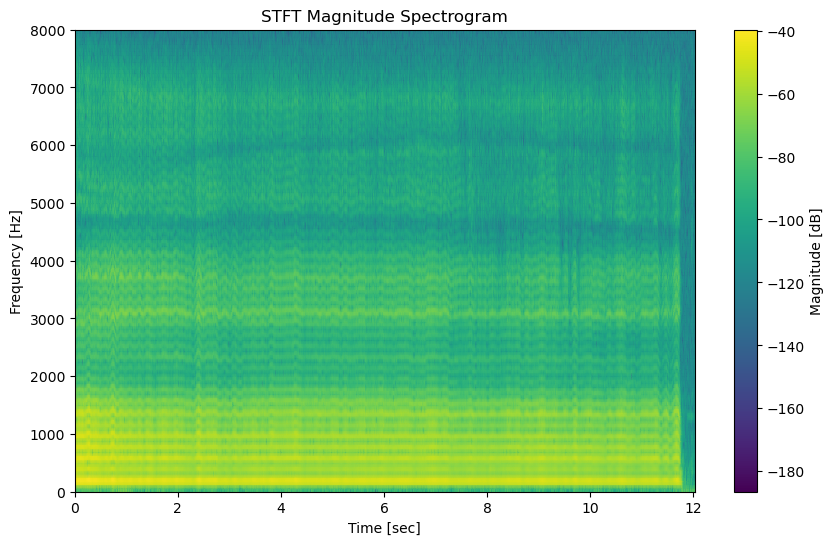

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
import soundfile as sf

filename = 'Parkinson\'s.wav'
x, fs = sf.read(filename)

f, t, Zxx = stft(x, fs=fs, window='hann', nperseg=256, noverlap=128)

magnitude = np.abs(Zxx)

plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, 20 * np.log10(magnitude), shading='gouraud')
plt.title('STFT Magnitude Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Magnitude [dB]')
plt.ylim(0, fs/2)
plt.show()


In [100]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

def extract_f0_autocorrelation(signal, rate, frame_size=0.03, hop_size=0.015):
    frame_len = int(frame_size * rate)
    hop_len = int(hop_size * rate)
    f0_values = []
    time_stamps = []

    for i in range(0, len(signal) - frame_len, hop_len):
        frame = signal[i:i + frame_len]
        frame = frame - np.mean(frame)

        autocorr = np.correlate(frame, frame, mode='full')
        autocorr = autocorr[len(autocorr) // 2:]

        d = np.diff(autocorr)
        start = np.where(d > 0)[0][0]
        peak = np.argmax(autocorr[start:]) + start

        f0 = rate / peak if peak > 0 else 0
        if 60 < f0 < 400:
            f0_values.append(f0)
        else:
            f0_values.append(np.nan)

        time_stamps.append(i / rate)

    return time_stamps, f0_values


In [101]:
rate, signal = wav.read("Parkinson's.wav")
if signal.ndim > 1:
    signal = signal.mean(axis=1)

signal = signal / np.max(np.abs(signal))

time_stamps, f0_values = extract_f0_autocorrelation(signal, rate)

valid_f0 = [f for f in f0_values if not np.isnan(f)]
if valid_f0:
    print(f"Average F0: {np.mean(valid_f0):.2f} Hz")
else:
    print("No valid F0 detected.")

print("First 5 F0 values:", valid_f0[:5])


Average F0: 193.85 Hz
First 5 F0 values: [195.1219512195122, 192.7710843373494, 195.1219512195122, 195.1219512195122, 197.53086419753086]


In [102]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

def autocorrelation(x, lag):
    return np.correlate(x, x, mode='full')[len(x)-1:len(x)+lag]

def levinson_durbin(r, order):
    a = np.zeros(order + 1)
    e = r[0]
    a[0] = 1.0

    for i in range(1, order + 1):
        acc = 0.0
        for j in range(1, i):
            acc += a[j] * r[i - j]
        k = (r[i] - acc) / e

        a_temp = a.copy()
        a[i] = k
        for j in range(1, i):
            a[j] = a_temp[j] - k * a_temp[i - j]

        e *= (1 - k**2)
        if e <= 0:
            break

    return a


def lpc_formants_manual(sig, rate, order=12):
    sig = np.append(sig[0], sig[1:] - 0.97 * sig[:-1])

    windowed = sig * np.hamming(len(sig))

    r = autocorrelation(windowed, order)

    A = levinson_durbin(r, order)

    roots = np.roots(A)
    roots = [r for r in roots if np.imag(r) >= 0]

    angles = np.angle(roots)
    freqs = sorted(angles * (rate / (2 * np.pi)))
    formants = [f for f in freqs if f > 90]

    while len(formants) < 4:
        formants.append(np.nan)

    return formants[:4]




In [103]:
rate, data = wav.read("Parkinson's.wav")
data = data[:rate * 1]
data = data.astype(np.float32)
formants = lpc_formants_manual(data, rate)
print("Formants (Hz):", formants)

f1_p, f2_p, f3_p, f4_p = lpc_formants_manual(data, rate)
print(f"F1–F4 (Hz): {f1_p:.2f}, {f2_p:.2f}, {f3_p:.2f}, {f4_p:.2f}")



Formants (Hz): [1162.2845919735244, 2663.673453286265, 3714.189491113524, 5378.190154637623]
F1–F4 (Hz): 1162.28, 2663.67, 3714.19, 5378.19


In [104]:
rate, data = wav.read("Healthy.wav")
data = data[:rate * 1]
data = data.astype(np.float32)
formants = lpc_formants_manual(data, rate)
print("Formants (Hz):", formants)

f1, f2, f3, f4 = lpc_formants_manual(data, rate)
print(f"F1–F4 (Hz): {f1:.2f}, {f2:.2f}, {f3:.2f}, {f4:.2f}")

Formants (Hz): [1424.1352293853963, 2613.6686286928507, 3752.628099992428, 8000.0]
F1–F4 (Hz): 1424.14, 2613.67, 3752.63, 8000.00


In [105]:
n = len(data)
freqs = np.fft.rfftfreq(n, d=1/rate)
spectrum = np.abs(np.fft.rfft(data))
spectrum_db = 20 * np.log10(spectrum + 1e-6)

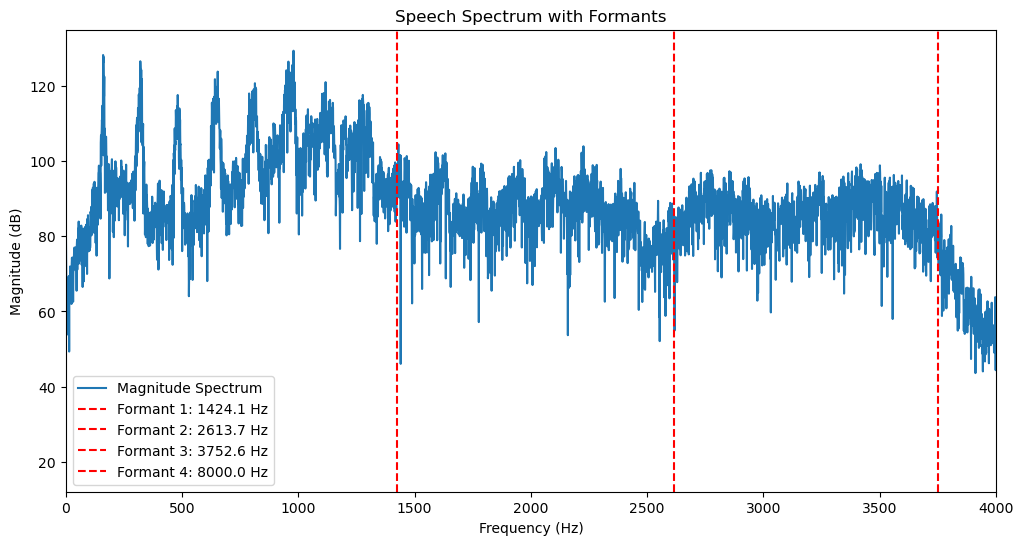

In [106]:
plt.figure(figsize=(12, 6))
plt.plot(freqs, spectrum_db, label='Magnitude Spectrum')

for f in formants:
    plt.axvline(x=f, color='r', linestyle='--', label=f'Formant {formants.index(f)+1}: {f:.1f} Hz')

plt.title("Speech Spectrum with Formants")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.xlim(0, 4000)
plt.show()

In [107]:
import numpy as np
import scipy.signal as signal
import scipy.io.wavfile as wav

def compute_snr(audio):
    estimated_signal = signal.convolve(audio, np.ones(10)/10, mode='same')

    noise = audio - estimated_signal

    signal_power = np.mean(estimated_signal**2)
    noise_power = np.mean(noise**2)

    snr = 10 * np.log10(signal_power / (noise_power + 1e-8))
    return snr


In [108]:
def compute_hnr(signal_data, fs):

    signal_data = signal_data - np.mean(signal_data)

    corr = np.correlate(signal_data, signal_data, mode='full')
    corr = corr[len(corr)//2:]

    peak_index = np.argmax(corr[1:]) + 1
    r0 = corr[0]
    rT = corr[peak_index]

    hnr = 10 * np.log10(rT / (r0 - rT + 1e-8))
    return hnr


In [109]:
def extract_voiced_segment(signal_data, rate, duration_ms=40):
    samples = int((duration_ms / 1000) * rate)
    center = len(signal_data) // 2
    return signal_data[center - samples//2 : center + samples//2]

In [110]:
import scipy.io.wavfile as wav
rate, healthy_data = wav.read("Healthy.wav")
print("Healthy data loaded with sample rate:", rate)
rate, parkinsons_data = wav.read("Parkinson's.wav")
print("Parkinson's data loaded with sample rate:", rate)

voiced_healthy = extract_voiced_segment(healthy_data, rate)
voiced_parkinsons = extract_voiced_segment(parkinsons_data, rate)

hnr_healthy = compute_hnr(voiced_healthy, rate)
hnr_parkinsons = compute_hnr(voiced_parkinsons, rate)

snr_healthy = compute_snr(voiced_healthy)
snr_parkinsons = compute_snr(voiced_parkinsons)

print(f"HNR (Healthy): {hnr_healthy:.2f} dB")
print(f"HNR (Parkinson's): {hnr_parkinsons:.2f} dB")
print(f"SNR (Healthy): {snr_healthy:.2f} dB")
print(f"SNR (Parkinson's): {snr_parkinsons:.2f} dB")


Healthy data loaded with sample rate: 16000
Parkinson's data loaded with sample rate: 16000
HNR (Healthy): 12.78 dB
HNR (Parkinson's): 15.84 dB
SNR (Healthy): 5.12 dB
SNR (Parkinson's): 9.83 dB


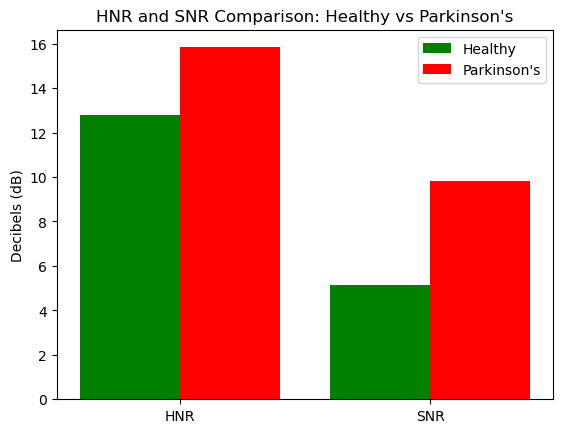

In [111]:
import matplotlib.pyplot as plt
hnr_healthy = hnr_healthy
hnr_parkinsons = hnr_parkinsons

snr_healthy = snr_healthy
snr_parkinsons = snr_parkinsons

labels = ['HNR', 'SNR']
healthy_values = [hnr_healthy, snr_healthy]
parkinsons_values = [hnr_parkinsons, snr_parkinsons]

x = range(len(labels))

plt.bar(x, healthy_values, width=0.4, label='Healthy', align='center', color='green')
plt.bar([i + 0.4 for i in x], parkinsons_values, width=0.4, label="Parkinson's", align='center',color='red')

plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel('Decibels (dB)')
plt.title('HNR and SNR Comparison: Healthy vs Parkinson\'s')
plt.legend()

plt.show()


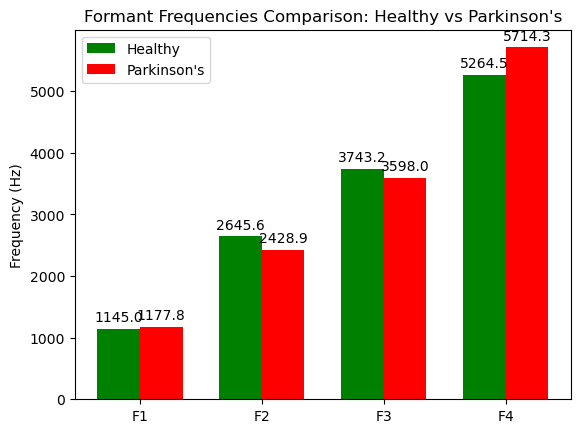

In [112]:
import matplotlib.pyplot as plt
import numpy as np

parkinsons_rate,parkinsons_signal = wav.read("Parkinson's.wav")
healthy_rate, healthy_signal = wav.read("Healthy.wav")
formants_healthy = lpc_formants_manual(parkinsons_signal,parkinsons_rate)
formants_parkinson = lpc_formants_manual(healthy_signal,healthy_rate)

f1_healthy, f2_healthy, f3_healthy, f4_healthy = formants_healthy
f1_parkinson, f2_parkinson, f3_parkinson, f4_parkinson = formants_parkinson

labels = ['F1', 'F2', 'F3', 'F4']
healthy_formants = [f1_healthy, f2_healthy, f3_healthy, f4_healthy]
parkinson_formants = [f1_parkinson, f2_parkinson, f3_parkinson, f4_parkinson]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, healthy_formants, width, label='Healthy', color='green')
rects2 = ax.bar(x + width/2, parkinson_formants, width, label="Parkinson's", color='red')

ax.set_ylabel('Frequency (Hz)')
ax.set_title('Formant Frequencies Comparison: Healthy vs Parkinson\'s')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


In [113]:
def pre_emphasis(signal, alpha=0.97):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

def framing(signal, rate, frame_size=0.025, hop_size=0.010):
    frame_len = int(frame_size * rate)
    hop_len = int(hop_size * rate)
    num_frames = int((len(signal) - frame_len) / hop_len) + 1
    frames = np.zeros((num_frames, frame_len))
    for i in range(num_frames):
        frames[i] = signal[i * hop_len:i * hop_len + frame_len]
    return frames

def apply_hamming(frames):
    window = np.hamming(frames.shape[1])
    return frames * window


def erb_scale(freq):
    return 24.7 * (4.37e-3 * freq + 1)

def make_gammatone_filters(fs, num_filters=13, low_freq=100, high_freq=None):
    if high_freq is None:
        high_freq = fs / 2
    return np.linspace(low_freq, high_freq, num_filters + 2)[1:-1]


In [114]:
from scipy.signal import butter, lfilter

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = fs / 2.0
    lowcut = max(lowcut, 1.0)
    highcut = min(highcut, nyq - 1.0)
    low = lowcut / nyq
    high = highcut / nyq
    if low >= high:
        return np.zeros_like(data)
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)
def compute_gammatone_energies(frames, rate, filterbank):
    energies = []

    for frame in frames:
        frame_energies = []
        for cf in filterbank:
            bandwidth = erb_scale(cf)
            filtered = bandpass_filter(frame, cf - bandwidth / 2, cf + bandwidth / 2, rate)
            energy = np.sum(filtered ** 2)
            frame_energies.append(np.log(energy + 1e-8))
        energies.append(frame_energies)

    return np.array(energies)


In [115]:
from scipy.fftpack import dct

def compute_gfcc(log_energies, num_ceps=13):
    return dct(log_energies, type=2, axis=1, norm='ortho')[:, :num_ceps]


In [116]:
from scipy.io import wavfile

def manual_gfcc_extraction(audio_path, return_all=False):
    rate, signal = wav.read(audio_path)
    if signal.ndim > 1:
        signal = signal.mean(axis=1)

    signal = signal / np.max(np.abs(signal))
    emphasized = pre_emphasis(signal)
    frames = framing(emphasized, rate)
    windowed = apply_hamming(frames)

    filterbank = make_gammatone_filters(rate)
    log_energies = compute_gammatone_energies(windowed, rate, filterbank)
    gfcc = compute_gfcc(log_energies)

    if return_all:
        return gfcc
    else:
        return np.mean(gfcc, axis=0)

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_gfcc_heatmap(gfcc_matrix, title):
    plt.figure(figsize=(10, 5))

    plt.imshow(gfcc_matrix, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Coefficient Value')
    plt.xlabel("Frame Index")
    plt.ylabel("GFCC Coefficient Index")
    plt.title(f"GFCC Heatmap - {title}")
    plt.tight_layout()
    plt.show()



In [118]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = fs / 2.0

    lowcut = max(lowcut, 1.0)
    highcut = min(highcut, nyq - 1.0)

    low = lowcut / nyq
    high = highcut / nyq

    if low >= high:
        return np.zeros_like(data)

    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)


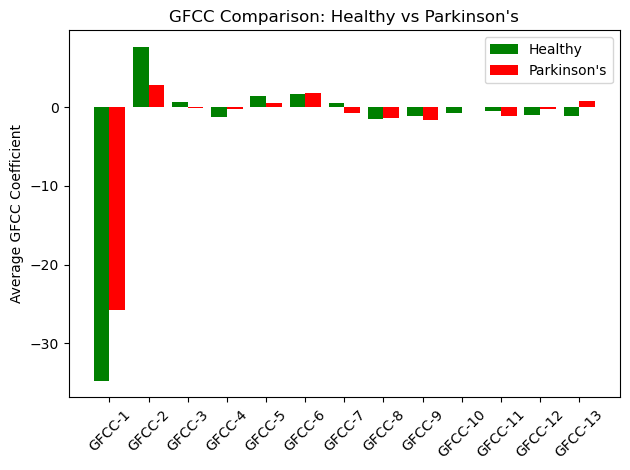

In [119]:
gfcc_healthy = manual_gfcc_extraction("Healthy.wav")
gfcc_parkinsons = manual_gfcc_extraction("Parkinson's.wav")

labels = [f"GFCC-{i+1}" for i in range(len(gfcc_healthy))]
x = np.arange(len(labels))

plt.bar(x - 0.2, gfcc_healthy, width=0.4, label='Healthy', color='green')
plt.bar(x + 0.2, gfcc_parkinsons, width=0.4, label='Parkinson\'s', color='red')
plt.xticks(x, labels, rotation=45)
plt.ylabel("Average GFCC Coefficient")
plt.title("GFCC Comparison: Healthy vs Parkinson's")
plt.legend()
plt.tight_layout()
plt.show()


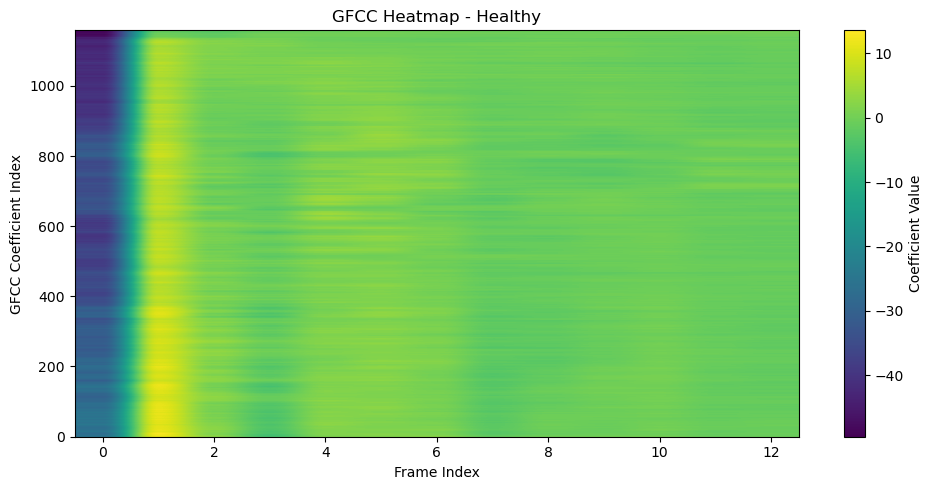

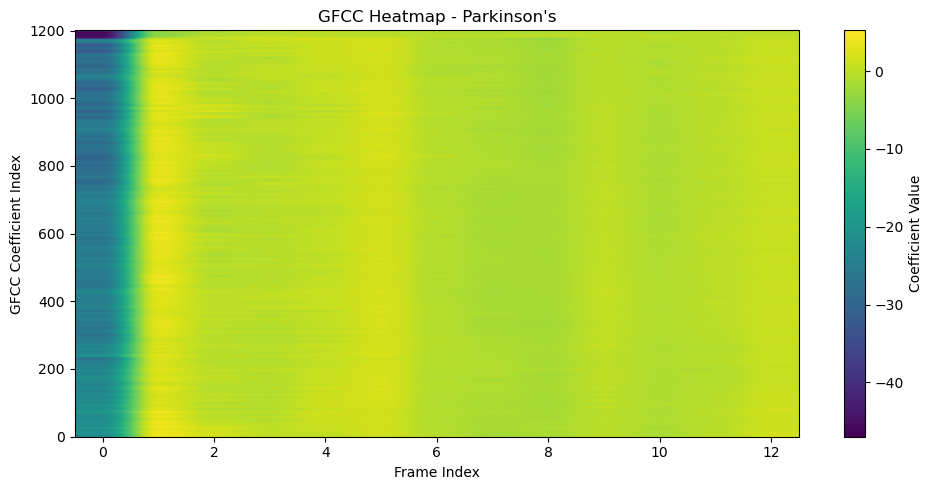

In [120]:
gfcc_healthy_full = manual_gfcc_extraction("Healthy.wav", return_all=True)
gfcc_parkinson_full = manual_gfcc_extraction("Parkinson's.wav", return_all=True)

plot_gfcc_heatmap(gfcc_healthy_full, "Healthy")
plot_gfcc_heatmap(gfcc_parkinson_full, "Parkinson's")


In [121]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

def compute_short_time_energy(signal, frame_size, hop_size):
    energy = []
    for start in range(0, len(signal) - frame_size, hop_size):
        frame = signal[start:start + frame_size]
        energy.append(np.sum(frame ** 2))
    return np.array(energy)

rate_healthy, data_healthy = wav.read("Healthy.wav")
rate_parkinson, data_parkinson = wav.read("Parkinson's.wav")

if len(data_healthy.shape) > 1:
    data_healthy = data_healthy[:, 0]
if len(data_parkinson.shape) > 1:
    data_parkinson = data_parkinson[:, 0]

frame_size = int(0.025 * rate_healthy)
hop_size = int(0.010 * rate_healthy)

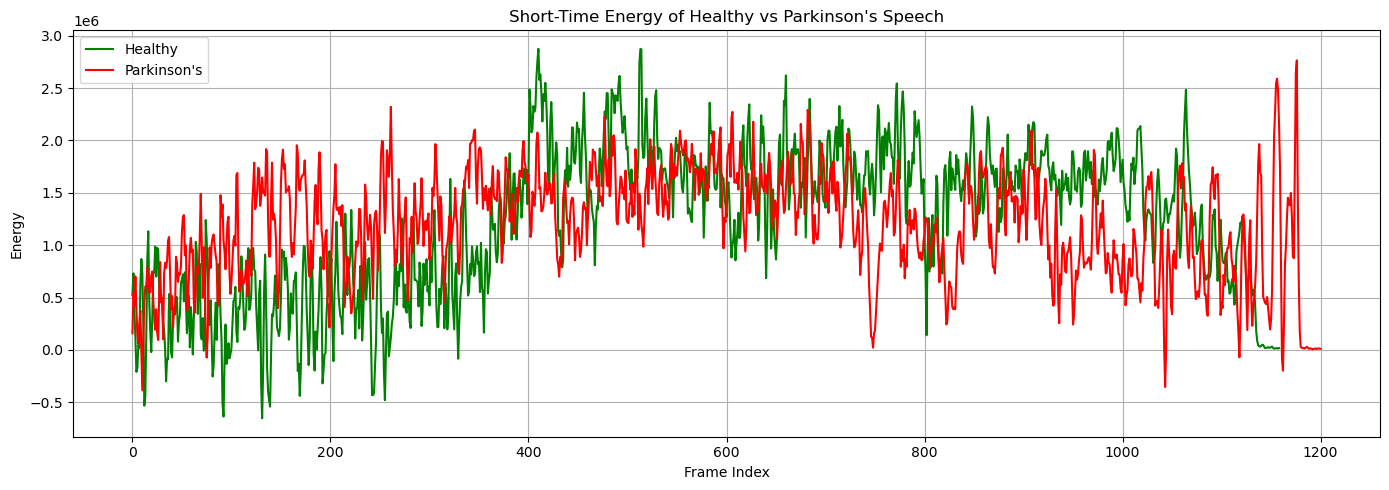

In [122]:
energy_healthy = compute_short_time_energy(data_healthy, frame_size, hop_size)
energy_parkinson = compute_short_time_energy(data_parkinson, frame_size, hop_size)

plt.figure(figsize=(14, 5))
plt.plot(energy_healthy, color='green', label='Healthy')
plt.plot(energy_parkinson, color='red', label="Parkinson's")
plt.title("Short-Time Energy of Healthy vs Parkinson's Speech")
plt.xlabel("Frame Index")
plt.ylabel("Energy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [123]:
def levinson_durbin(r, order):
    a = np.zeros(order + 1)
    e = r[0]
    a[0] = 1

    for i in range(1, order + 1):
        acc = sum(a[j] * r[i - j] for j in range(1, i))
        k = (r[i] - acc) / e
        a_temp = a.copy()
        for j in range(1, i):
            a[j] = a_temp[j] - k * a_temp[i - j]
        a[i] = k
        e *= (1 - k ** 2)

    return a, e


In [124]:
def lpc_to_lpcc(a, p, n):
    lpcc = np.zeros(n)
    lpcc[0] = -np.log(a[0]) if a[0] > 0 else 0
    for m in range(1, n):
        acc = 0
        for k in range(1, m):
            acc += (k / m) * lpcc[k] * a[m - k]
        if m < len(a):
            lpcc[m] = a[m] + acc
        else:
            lpcc[m] = acc
    return lpcc

def manual_lpcc_extraction(path, order=12, num_ceps=13):
    rate, signal = wav.read(path)
    if signal.ndim > 1:
        signal = signal.mean(axis=1)

    signal = signal / np.max(np.abs(signal))
    emphasized = pre_emphasis(signal)
    frames = framing(emphasized, rate)
    windowed = apply_hamming(frames)

    lpccs = []
    for frame in windowed:
        r = autocorrelation(frame, order)
        a, e = levinson_durbin(r, order)
        lpcc = lpc_to_lpcc(a, order, num_ceps)
        lpccs.append(lpcc)

    return np.array(lpccs)

In [125]:
lpcc_healthy = manual_lpcc_extraction("Healthy.wav")
lpcc_parkinson = manual_lpcc_extraction("Parkinson's.wav")

print("Healthy LPCC shape:", lpcc_healthy.shape)
print("Parkinson LPCC shape:", lpcc_parkinson.shape)


Healthy LPCC shape: (1159, 13)
Parkinson LPCC shape: (1201, 13)


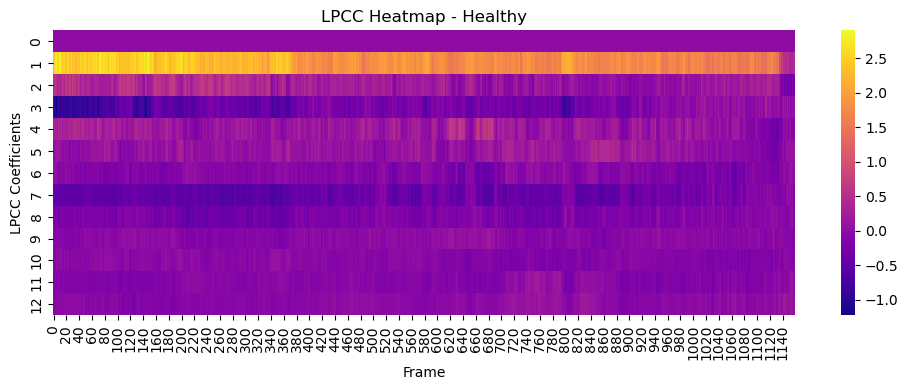

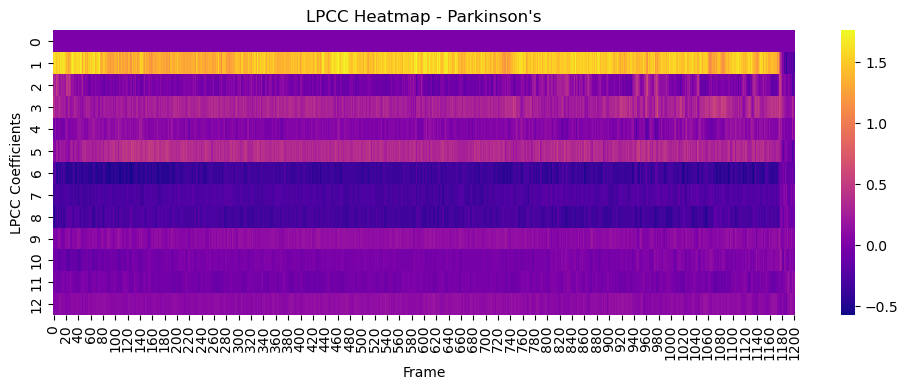

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_lpcc_heatmap(lpcc, title):
    plt.figure(figsize=(10, 4))
    sns.heatmap(lpcc.T, cmap="plasma", xticklabels=20)
    plt.title(f"LPCC Heatmap - {title}")
    plt.xlabel("Frame")
    plt.ylabel("LPCC Coefficients")
    plt.tight_layout()
    plt.show()

plot_lpcc_heatmap(lpcc_healthy, "Healthy")
plot_lpcc_heatmap(lpcc_parkinson, "Parkinson's")


In [127]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [128]:
for name, var in zip(["f0", "f1", "f2", "f3", "f4", "jitter", "shimmer", "mfcc", "gfcc", "lpc", "snr", "hnr","lpcc"],
                     [f0_values, f1, f2, f3, f4, jitter_healthy, shimmer_healthy,
                      mfcc_healthy, gfcc_healthy, lpc_healthy, snr_healthy, hnr_healthy,lpcc_healthy]):
    print(f"{name}: {np.shape(var)}")


f0: (801,)
f1: ()
f2: ()
f3: ()
f4: ()
jitter: ()
shimmer: ()
mfcc: (1159, 13)
gfcc: (13,)
lpc: (13,)
snr: ()
hnr: ()
lpcc: (1159, 13)


In [129]:
import numpy as np
f0_mean = np.mean(f0_values)
f0_std = np.std(f0_values)

mfcc_mean = np.mean(mfcc_healthy, axis=0)
mfcc_std = np.std(mfcc_healthy, axis=0)

features_healthy = np.hstack([
    f0_mean, f0_std,
    f1, f2, f3, f4,
    jitter_healthy, shimmer_healthy,
    mfcc_mean, mfcc_std,
    gfcc_healthy, lpc_healthy,
    snr_healthy, hnr_healthy
])


In [130]:
def extract_features(f0, f1, f2, f3, f4,
                     jitter, shimmer,
                     mfcc, gfcc, lpc, lpcc,
                     snr, hnr):

    f0_mean = np.mean(f0)
    f0_std = np.std(f0)

    mfcc_mean = np.mean(mfcc, axis=0)
    mfcc_std = np.std(mfcc, axis=0)

    lpcc_mean = np.mean(lpcc, axis=0)
    lpcc_std = np.std(lpcc, axis=0)

    feature_vector = np.hstack([
        f0_mean, f0_std,
        f1, f2, f3, f4,
        jitter, shimmer,
        mfcc_mean, mfcc_std,
        gfcc,
        lpc,
        lpcc_mean, lpcc_std,
        snr, hnr
    ])
    return feature_vector

In [131]:
features_healthy = extract_features(
    f0_values, f1, f2, f3, f4,
    jitter_healthy, shimmer_healthy,
    mfcc_healthy, gfcc_healthy, lpc_healthy, lpcc_healthy,
    snr_healthy, hnr_healthy
)

features_parkinson = extract_features(
    f0_values, f1_p, f2_p, f3_p, f4_p,
    jitter_parkinson, shimmer_parkinson,
    mfcc_parkinson, gfcc_parkinsons, lpc_parkinson, lpcc_parkinson,
    snr_parkinsons, hnr_parkinsons
)


In [132]:
X_raw = np.vstack([features_healthy, features_parkinson])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
features_healthy_scaled = X_scaled[0]
features_parkinson_scaled = X_scaled[1]
X = np.vstack([features_healthy_scaled, features_parkinson_scaled])
y = np.array([0, 1])


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [133]:
import numpy as np

f0 = np.mean(f0_values) if len(f0_values) > 0 else 0
mfcc_mean = np.mean(mfcc_healthy, axis=0) if mfcc_healthy is not None else np.zeros(13)
gfcc_mean = np.mean(gfcc_healthy) if gfcc_healthy is not None else 0
lpc_mean = np.mean(lpc_healthy) if lpc_healthy is not None else 0
lpcc_mean = np.mean(lpcc_healthy, axis=0) if lpcc_healthy is not None else np.zeros(13)

features_healthy_scaled = np.concatenate([
    [f0, f1, f2, f3, f4,
     jitter_healthy, shimmer_healthy,
     snr_healthy, hnr_healthy],
    mfcc_mean.flatten(),
    [gfcc_mean],
    [lpc_mean],
    lpcc_mean.flatten()
])



In [134]:
f0_p = np.mean(f0_values) if len(f0_values) > 0 else 0
mfcc_mean_p = np.mean(mfcc_parkinson, axis=0) if mfcc_parkinson is not None else np.zeros(13)
gfcc_mean_p = np.mean(gfcc_parkinsons) if gfcc_parkinsons is not None else 0
lpc_mean_p = np.mean(lpc_parkinson) if lpc_parkinson is not None else 0
lpcc_mean_p = np.mean(lpcc_parkinson, axis=0) if lpcc_parkinson is not None else np.zeros(13)

features_parkinson_scaled = np.concatenate([
    [f0_p, f1_p, f2_p, f3_p, f4_p,
     jitter_parkinson, shimmer_parkinson,
     snr_parkinsons, hnr_parkinsons],
    mfcc_mean_p.flatten(),
    [gfcc_mean_p],
    [lpc_mean_p],
    lpcc_mean_p.flatten()
])


In [135]:
import numpy as np

print("Are there NaNs in X?", np.isnan(X).any())
print("Indices of NaNs:", np.where(np.isnan(X)))


Are there NaNs in X? True
Indices of NaNs: (array([0, 0, 1, 1]), array([0, 1, 0, 1]))


In [136]:
import numpy as np
X = np.vstack([features_healthy_scaled, features_parkinson_scaled])
X[np.isnan(X)] = 0

from sklearn.svm import SVC
y = np.array([0, 1])

model = SVC(kernel='linear')
model.fit(X, y)
predictions = model.predict(X)
print("Predictions:", predictions)



Predictions: [0 1]


In [137]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [152]:
import numpy as np
X = np.vstack([features_healthy_scaled, features_parkinson_scaled])
X[np.isnan(X)] = 0

from sklearn.svm import SVC
y = np.array([0, 1])

model = SVC(kernel='rbf')
model.fit(X, y)
predictions = model.predict(X)
print("Predictions:", predictions)

Predictions: [0 1]


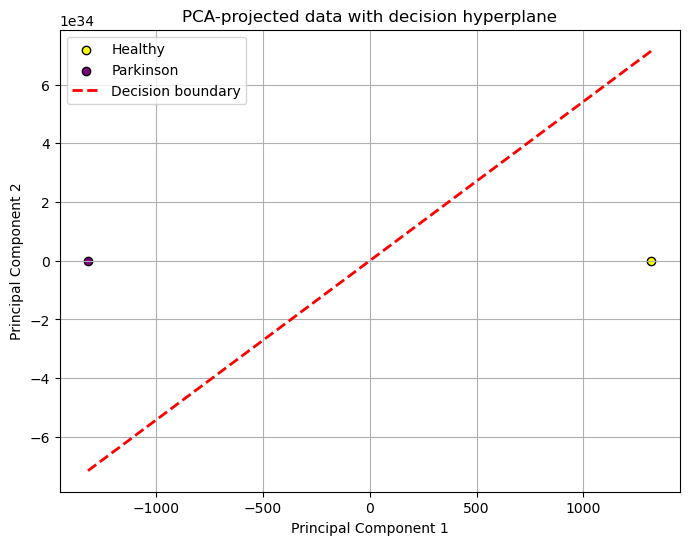

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

model = LogisticRegression()
model.fit(X_pca, y)

w = model.coef_[0]  
b = model.intercept_[0]

x_min, x_max = X_pca[:,0].min() - 1, X_pca[:,0].max() + 1
x_vals = np.linspace(x_min, x_max, 200)
y_vals = -(w[0] / w[1]) * x_vals - b / w[1]

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1],
            color='yellow', edgecolors='k', label='Healthy')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1],
            color='purple', edgecolors='k', label='Parkinson')

plt.plot(x_vals, y_vals, 'r--', linewidth=2, label='Decision boundary')

plt.title("PCA-projected data with decision hyperplane")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

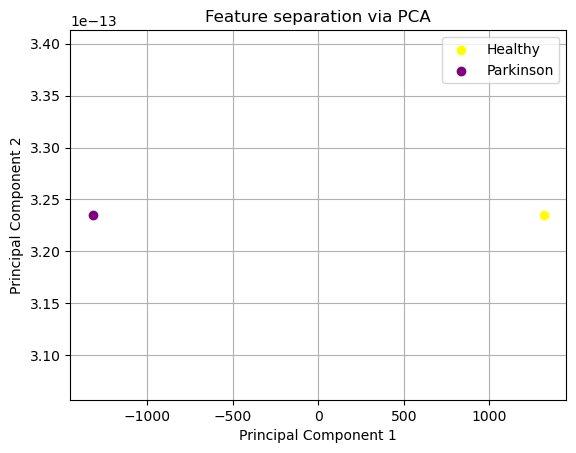

In [154]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[0, 0], X_pca[0, 1], color='yellow', label='Healthy')
plt.scatter(X_pca[1, 0], X_pca[1, 1], color='purple', label='Parkinson')

plt.title("Feature separation via PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2") 
plt.legend()
plt.grid(True)
plt.show()



In [155]:
print("PCA components (X_pca):\n", X_pca)

PCA components (X_pca):
 [[ 1.31781244e+03  3.23508586e-13]
 [-1.31781244e+03  3.23508586e-13]]


In [157]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm_model = SVC()  
svm_model.fit(X, y)

predictions = svm_model.predict(X)
accuracy = accuracy_score(y, predictions)

print("Training Accuracy:", accuracy * 100, "%")


Training Accuracy: 100.0 %


In [143]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [144]:
model.fit(X, y)
predictions = model.predict(X)
print("Predictions:", predictions)

Predictions: [0 1]


In [145]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

probs = model.predict_proba(X)
print("Prediction Probabilities:\n", probs)

Prediction Probabilities:
 [[0.78 0.22]
 [0.26 0.74]]


In [146]:
import numpy as np

importances = model.feature_importances_
for i, imp in enumerate(importances):
    print(f"Feature {i+1}: Importance = {imp:.4f}")


Feature 1: Importance = 0.0000
Feature 2: Importance = 0.0192
Feature 3: Importance = 0.0000
Feature 4: Importance = 0.0000
Feature 5: Importance = 0.0000
Feature 6: Importance = 0.0577
Feature 7: Importance = 0.0577
Feature 8: Importance = 0.0192
Feature 9: Importance = 0.0192
Feature 10: Importance = 0.0192
Feature 11: Importance = 0.0385
Feature 12: Importance = 0.0192
Feature 13: Importance = 0.0385
Feature 14: Importance = 0.0192
Feature 15: Importance = 0.0962
Feature 16: Importance = 0.0192
Feature 17: Importance = 0.0577
Feature 18: Importance = 0.0000
Feature 19: Importance = 0.0000
Feature 20: Importance = 0.0577
Feature 21: Importance = 0.0192
Feature 22: Importance = 0.0769
Feature 23: Importance = 0.0192
Feature 24: Importance = 0.0192
Feature 25: Importance = 0.0000
Feature 26: Importance = 0.0577
Feature 27: Importance = 0.0000
Feature 28: Importance = 0.0000
Feature 29: Importance = 0.0192
Feature 30: Importance = 0.0385
Feature 31: Importance = 0.0000
Feature 32: Impor

In [147]:
X_new = X.copy()
X_new[1][0] += 0.5  
print("New prediction:", model.predict(X_new))


New prediction: [0 1]


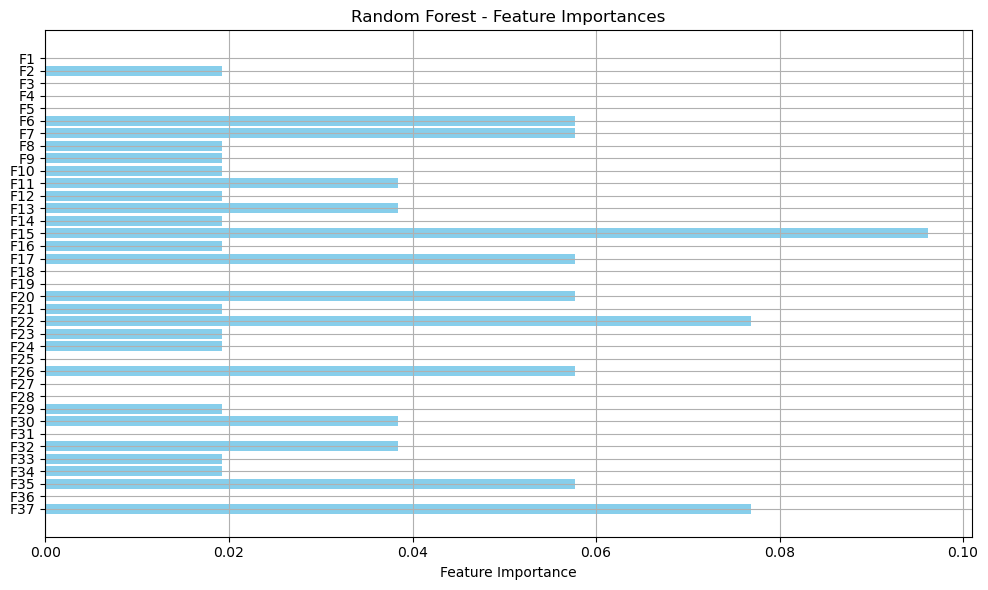

In [148]:
import numpy as np
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = [f'F{i+1}' for i in range(X.shape[1])]

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest - Feature Importances")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

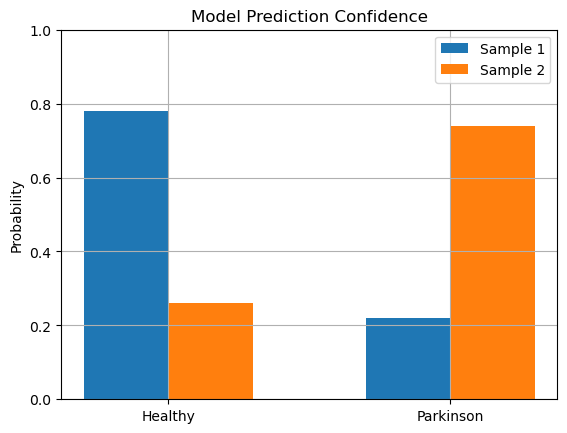

In [149]:
probs = model.predict_proba(X)

labels = ['Healthy', 'Parkinson']
x = np.arange(len(labels))

for i, sample_probs in enumerate(probs):
    plt.bar(x + i*0.3, sample_probs, width=0.3, label=f"Sample {i+1}")

plt.xticks(x + 0.15, labels)
plt.ylabel("Probability")
plt.title("Model Prediction Confidence")
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [150]:
from sklearn.metrics import classification_report

print(classification_report(y, predictions, target_names=["Healthy", "Parkinson"]))

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00         1
   Parkinson       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [151]:
from sklearn.metrics import accuracy_score

predictions = model.predict(X)
accuracy = accuracy_score(y, predictions)

print("Training Accuracy:", accuracy * 100, "%")

Training Accuracy: 100.0 %
